# Computer Detection of Algal Blooms

![algal bloom](download.jpeg)

## The problem 

Phytoplankton are single-celled algae that live in freshwater, saltwater, and everywhere in between. Algal blooms, big explosions of phytoplankton growth, happen naturally every late spring and early fall all around the globe. Sometimes, blooms grow out of control for a variety of reasons: excess of nutrient from land based runoff, influx of freshwater, higher than normal temperatures. These are called Harmful Algal Blooms (HABs). HABs pose a threat to human health and ecosystem health. 

![hab facts](download1.jpeg)

Early detection of algal blooms from imagery can help scientists and policy makers sample blooms as soon as possible to determine if they are toxic, and make important decisions regarding public health: beach closures, fisherman warnings, and seafood warnings can all help humans avoid harmful effects of HABS. My goal is to create a model that classifies algal blooms using imagery obtained from Google. Algal blooms come in all differnet shapes, sizes and colors, and this highly varied dataset will hopefully lead to a model that is able to classsify algal blooms in all forms. 

In [26]:
import pandas as pd
import numpy as np
import os
import glob
import  PIL
from PIL import Image
import cv2
import time
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
%matplotlib inline

# custom function
from data_cleaning import *

## Image Preprocessing

In [27]:
# talk about split.py 

In [28]:
# get_img_stats is a function loaded in from data_cleaning.py
# it loops through each directory and gets the dimensions of each image and prints the minimum
test_algae = "split/test/algae/*"
test_not_algae = "split/test/not_algae/*"
get_img_stats(test_algae)
get_img_stats(test_not_algae)

train_algae = "split/train/algae/*"
train_not_algae = "split/train/not_algae/*"
get_img_stats(train_algae)
get_img_stats(train_not_algae)

val_algae = "split/validation/algae/*"
val_not_algae = "split/validation/not_algae/*"
get_img_stats(val_algae)
get_img_stats(val_not_algae)

images appended!
(140, 100)
images appended!
(160, 237)
images appended!
(140, 100)
images appended!
(153, 110)
images appended!
(140, 100)
images appended!
(200, 160)


In [29]:
# rescale and reshape the images

train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    'split/train/', target_size=(140,140), batch_size=871)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    'split/test/', target_size=(140,140), batch_size=291)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    'split/validation/', target_size=(140,140), batch_size=294)

Found 867 images belonging to 2 classes.
Found 288 images belonging to 2 classes.
Found 291 images belonging to 2 classes.


In [30]:
# split the images and labels
train_images, train_labels = next(train_gen)
test_images, test_labels = next(test_gen)
val_images, val_labels = next(val_gen)

## Split the data

In [31]:
# split into x & y and check shape
train_img = train_images
test_img = test_images
val_img = val_images

print("Train X:", train_img.shape)
print("Test X:", test_img.shape)
print("Val X:", val_img.shape)

train_y = train_labels
test_y = test_labels
val_y = val_labels

print("\n")
print("Train y:", train_y.shape)
print("Test y:", test_y.shape)
print("Val y:", val_y.shape)

Train X: (867, 140, 140, 3)
Test X: (288, 140, 140, 3)
Val X: (291, 140, 140, 3)


Train y: (867, 2)
Test y: (288, 2)
Val y: (291, 2)


## Design a base model

In [32]:
# instantiate the model 
model = models.Sequential()

# you need alternating convolutional and pooling layers
# first kernel_size is 7x7 because my image size is > 128x128
# source: https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/

model.add(layers.Conv2D(32, (7, 7), activation='relu',
                        input_shape=(140, 140, 3))) # in the first layer add an input shape
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

# add in metrics for evaluations
model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [33]:
# evaluate base model
history = model.fit(#train_img,
                    #train_y,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Train on 867 samples, validate on 291 samples
Epoch 1/30
867/867 [==============================] - 28s 32ms/step - loss: 0.6825 - acc: 0.5882 - val_loss: 0.6683 - val_acc: 0.5378
Epoch 2/30
867/867 [==============================] - 25s 29ms/step - loss: 0.6269 - acc: 0.7191 - val_loss: 0.6674 - val_acc: 0.5550
Epoch 3/30
867/867 [==============================] - 25s 29ms/step - loss: 0.5505 - acc: 0.7238 - val_loss: 0.5516 - val_acc: 0.6718
Epoch 4/30
867/867 [==============================] - 25s 29ms/step - loss: 0.5256 - acc: 0.7301 - val_loss: 0.4305 - val_acc: 0.8419
Epoch 5/30
867/867 [==============================] - 25s 29ms/step - loss: 0.4667 - acc: 0.7630 - val_loss: 1.3632 - val_acc: 0.5292
Epoch 6/30
867/867 [==============================] - 25s 28ms/step - loss: 0.5048 - acc: 0.7532 - val_loss: 0.4706 - val_acc: 0.7646
Epoch 7/30
867/867 [==============================] - 25s 29ms/step - loss: 0.4548 - acc: 0.7930 - val_loss: 1.2661 - val_acc: 0.5395
Epoch 8/30
867/8

In [34]:
results_train = model.evaluate(train_img, train_y)
results_train

867/867 [==============================] - 6s 7ms/step


[0.9110229510337011, 0.6851211190223694]

In [35]:
results_test = model.evaluate(test_img, test_y)
results_test

288/288 [==============================] - 2s 7ms/step


[1.0830462906095717, 0.640625]

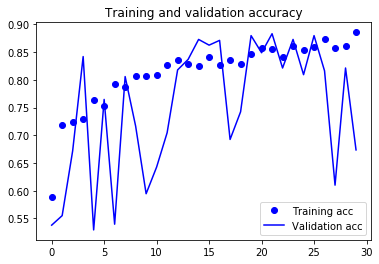

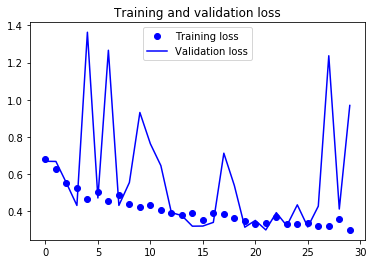

In [37]:
# to mass comment out: select all and ctrl + / 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [40]:
# save model 
model.save('hab_base_model.h5')

## Design an augmented model

In [41]:
# augmentation 
# reshape the images, flip, rotate and adjust brightness using Keras

test_generator = ImageDataGenerator(rescale=1./255)

train_generator = ImageDataGenerator(rescale=1./255, 
                                     rotation_range=90, 
                                     brightness_range=[0.2,1.5], 
                                     horizontal_flip=True).flow_from_directory('split/train/', 
                                                                               target_size=(140, 140), 
                                                                               batch_size=871)

val_generator = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=90,
                                   brightness_range=[0.2,1.5], 
                                   horizontal_flip=True).flow_from_directory('split/validation/', 
                                                                             target_size=(140, 140), 
                                                                             batch_size = 294)

Found 867 images belonging to 2 classes.
Found 291 images belonging to 2 classes.


In [42]:
# evaluate augmented model
history = model.fit(train_img,
                    train_y,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Train on 867 samples, validate on 291 samples
Epoch 1/30
867/867 [==============================] - 30s 35ms/step - loss: 0.3267 - acc: 0.8627 - val_loss: 0.2939 - val_acc: 0.9003
Epoch 2/30
867/867 [==============================] - 25s 29ms/step - loss: 0.2951 - acc: 0.8870 - val_loss: 1.1827 - val_acc: 0.6031
Epoch 3/30
867/867 [==============================] - 25s 29ms/step - loss: 0.3406 - acc: 0.8697 - val_loss: 0.4541 - val_acc: 0.7990
Epoch 4/30
867/867 [==============================] - 27s 31ms/step - loss: 0.3082 - acc: 0.8697 - val_loss: 0.2944 - val_acc: 0.8866
Epoch 5/30
867/867 [==============================] - 26s 30ms/step - loss: 0.3205 - acc: 0.8679 - val_loss: 0.2916 - val_acc: 0.8900
Epoch 6/30
867/867 [==============================] - 25s 28ms/step - loss: 0.2959 - acc: 0.8875 - val_loss: 0.2944 - val_acc: 0.8849
Epoch 7/30
867/867 [==============================] - 25s 29ms/step - loss: 0.2788 - acc: 0.8899 - val_loss: 0.3070 - val_acc: 0.8797
Epoch 8/30
867/8

In [43]:
# Final evaluation
results_train = model.evaluate(train_img, train_y)
results_train

867/867 [==============================] - 6s 7ms/step


[0.40962312904196213, 0.8437139391899109]

In [44]:
results_test = model.evaluate(test_img, test_y)
results_test

288/288 [==============================] - 2s 7ms/step


[0.686707980102963, 0.7777777910232544]

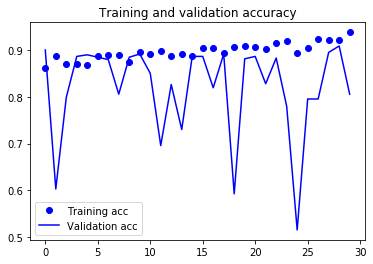

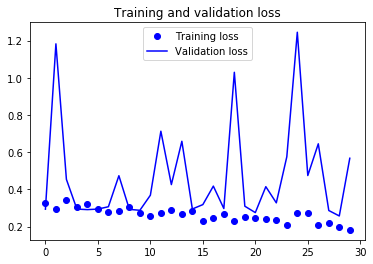

In [45]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [46]:
model.save('hab_augmented_model.h5')

In [1]:
# final results 
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(150, 150), 
                                                  batch_size=20, 
                                                  class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

NameError: name 'test_datagen' is not defined

In [ ]:
# results, conclusions

In [ ]:
# build new model